# Bank Data Analysis

## Motivations

#### Outline
The purpose of this notebook is do to a rudimental analysis of the **Bank Marketing Data Set** to reach a reasonable degree of accuracy when predicting whether a client will subscribe to a term deposit, and then perform a simple **Bayesian search** using the *scikit-optimise* Python library to find a (near) optimal learning rate.

#### Business Application
In a business setting, a detailed analysis of this dataset might be done to determine how to be go about a telemarketing campaign. By performing an accurate prediction, we get a better sense of which features most affect the chance of a customer subscribing to a particular service provided by the bank. The bank can then focus their efforts on the features which increase the likelihood of the customer subscribing to a service. 

#### Academic Application
From an academic standpoint, this analysis is a good way to understand how to use the *scikit-optimise* library to perform Bayesian Optimisation. This may not be the best library to perform a Bayesian search, however this is well known to be a easy to use and provide a wide range of functionality. From some prior reading, this dataset is imbalanced. A major challenge when analysing this will arise from how to handle this, without causing a large bias in the results or overfitting due to the majority label.

### Contents

1. [Loading Dataset](#loading-dataset)  
    1.1. Encoding Labels <br>
    1.2. Train-Test Split <br> <br>

2. [Feautre Analysis & Exploration](#feature-analysis) <br>
    2.1 Initial Data Exploration <br>
    2.2 Data Visualisation <br>
    2.3 Preprocessing <br>
    2.4 Writing Bespoke Transformers in Sklearn <br>
    2.5 2D Data Visualisation <br>
    2.6 Removing Outliers <br> <br>

3. [Models](#models) <br>
    3.1 Baseline Models <br>
    3.2 Feature Importance <br>
    3.3 Model Comparison <br>
    3.4 Final Model <br> <br>

4. [Tuning](#tuning) <br>
    4.1 Grid Search <br>
    4.2 **Bayesian Search** - using scikit-optimise <br> <br>

5. [Evaluation](#evaluation)
6. [References](#references)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
plt.style.use("Solarize_Light2")

## <span id="loading-dataset"> Loading Dataset </span>

In [3]:
df = pd.read_csv("./bank-full.csv", delimiter=";")
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


### Encoding Labels

In [49]:
from sklearn.preprocessing import LabelBinarizer

X = df.drop("y", axis=1)
y = df.loc[:, "y"]

lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

print(lb.classes_)
y_encoded

['no' 'yes']


array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

### Train-Test split

Split the dataset into a **training and test** sections. The test set will not be used to train any models which are build but will be used when evaluating the performance of a model. It is often common practice to split the training section further into a **validation (developmental) set** also, which is used for evaluating models, with the test set being used to evaluate performance at the very end. I have not done this.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.1, random_state=42)

## <span id="feature-analysis"> Features Analysis & Engineering </span>

### Initial Data Exploration

Initially, we examine the different types of features in the dataframe. This gives us a sense of how much work we will need to do clean up the dataset (i.e. which columns need to be discretizing or encoding etc.) before it is ready to pass into an algorithm. **We can also determine whether any of these features are categorical or continuous** by seeing what kind of values are in a particular column and how many these are.

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 14565 to 15795
Data columns (total 16 columns):
age          40689 non-null int64
job          40689 non-null object
marital      40689 non-null object
education    40689 non-null object
default      40689 non-null object
balance      40689 non-null int64
housing      40689 non-null object
loan         40689 non-null object
contact      40689 non-null object
day          40689 non-null int64
month        40689 non-null object
duration     40689 non-null int64
campaign     40689 non-null int64
pdays        40689 non-null int64
previous     40689 non-null int64
poutcome     40689 non-null object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


In [7]:
features = X_train.columns

for col in features:
    print(col)
    unique = X_train.loc[:, col].unique()
    if len(unique) < 100:
        print(unique)
    print()

age
[29 57 54 52 34 50 40 43 59 53 35 49 32 28 56 27 39 58 60 41 51 30 33 36
 46 31 42 44 48 26 55 25 80 47 23 37 45 38 68 20 79 67 65 64 22 62 73 24
 61 21 70 74 82 75 71 76 77 66 86 18 69 83 63 87 81 78 84 19 93 72 89 85
 90 94 92 88 95]

job
['housemaid' 'management' 'blue-collar' 'services' 'admin.' 'technician'
 'unemployed' 'retired' 'self-employed' 'entrepreneur' 'unknown' 'student']

marital
['married' 'divorced' 'single']

education
['primary' 'secondary' 'tertiary' 'unknown']

default
['no' 'yes']

balance

housing
['yes' 'no']

loan
['no' 'yes']

contact
['cellular' 'unknown' 'telephone']

day
[15 12  5 10  4  6 16 17 21 28 23 27  2 29  9 26 31 22 13 30  3  8 20 18
  7 14 11 25  1 19 24]

month
['jul' 'aug' 'may' 'nov' 'jun' 'apr' 'jan' 'feb' 'oct' 'mar' 'sep' 'dec']

duration

campaign
[ 3  2  1  4  6 18  8 14 21  5 10 20 13 11 16  7 17 12  9 22 15 28 27 32
 30 55 19 26 23 37 29 36 25 31 24 34 33 63 46 38 35 39 43 41 50 58 44 51]

pdays

previous
[  0   2   5   1  23  17   

### Data Visualisation

From the cell above, we can see that are many datapoints marked as ** *unknown* ** across multiple features. The below graphs show the distribution of the different categories within certain features in the dataset. There are many ** *unknown* ** datapoints in the ** *poutcome* ** feature but not as many in others. For this reason, it might make sense to drop the ** *poutcome* ** column. For the other features, since the fraction of *unknown* datapoints is not as high, we can do one of two things: 

   * Imputation to predict the values of the unknowns. 
   * Drop the unknowns rows if there are not as many. 


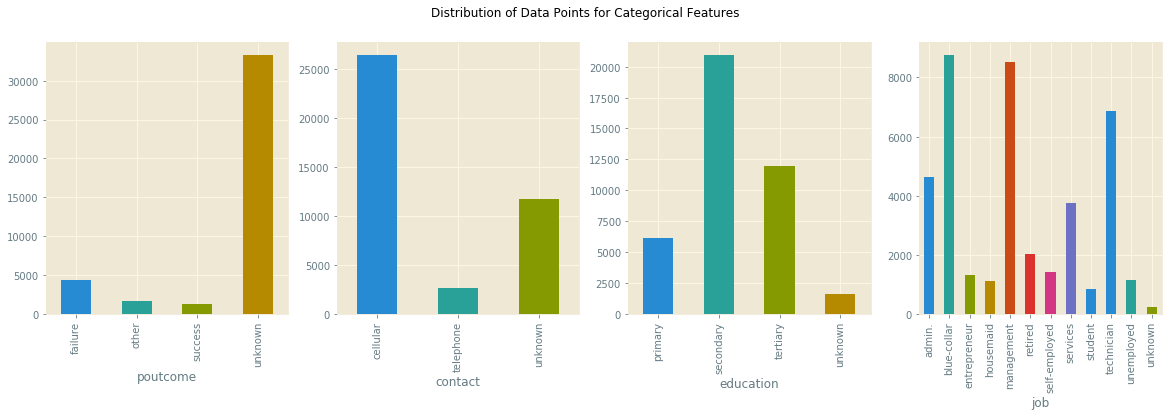

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=4)

fig.suptitle("Distribution of Data Points for Categorical Features")

for i, col in enumerate(["poutcome", "contact", "education", "job"]):
    X_train.groupby(col).count().previous.plot('bar', figsize=(20, 5), ax=axes[i])

The below graph show us the frequency of unique values for each feature. If there were too many unique values for a feature it might have been worth discretizing it for the purpose of this problem.

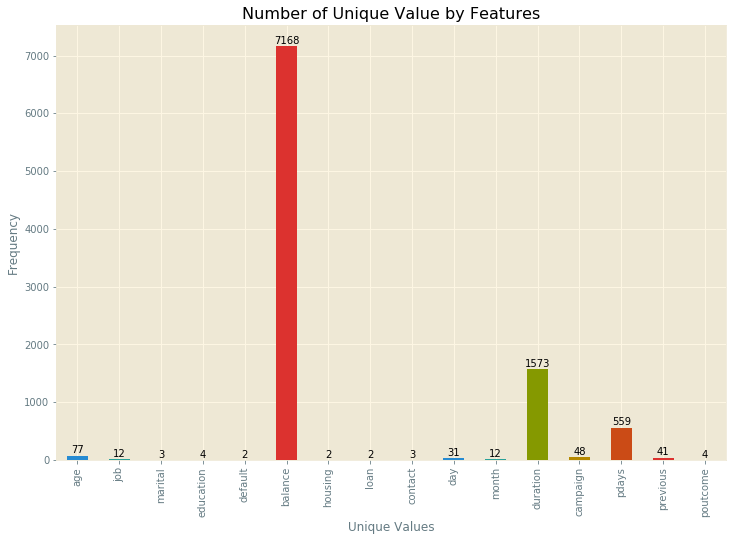

In [9]:
features = X_train.columns
unique_vals = [len(df.loc[:, col].unique()) for col in features]
freq_series = pd.Series(unique_vals)

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Number of Unique Value by Features')
ax.set_xlabel('Unique Values')
ax.set_ylabel('Frequency')
ax.set_xticklabels(features)

# Add value labels for each bar
rects = ax.patches

for rect, label in zip(rects, unique_vals):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

In [62]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
14565,29,housemaid,married,primary,no,0,yes,no,cellular,15,jul,317,3,-1,0,unknown
20546,57,management,divorced,secondary,no,396,no,no,cellular,12,aug,108,2,-1,0,unknown
34495,54,blue-collar,married,primary,no,714,no,no,cellular,5,may,225,1,-1,0,unknown
13814,52,services,married,secondary,no,2072,no,no,cellular,10,jul,224,1,-1,0,unknown
42153,34,management,married,tertiary,no,1778,no,no,cellular,4,nov,358,1,162,2,failure


### Preprocessing 

From the previous conclusions we need to perform some transformations on our dataset so that we can fit a model on it without having to lose too much information (i.e. delete too many rows or columns). The main way to do this is to encode the categorical features which are not integers. 

In the case of the ** *month* ** and ** *education* ** features, I have given them specific numbers, as opposed to using the sklearn encoders, since I want to enforce some kind of order on these data points. This ordering may be useful when looking for correlations and identifying redundant data points or when making conclusions on the final set of predictions, such as noticing seasonlity trends. **Having a known ordering can make the results easier to interpret.**

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

corr_df = X_train.copy()

months = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6, 
          "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}
corr_df.month = corr_df.month.apply(lambda x: months[x])

edu = {"unknown": 0, "primary": 1, "secondary": 2, "tertiary": 3}
corr_df.education = corr_df.education.apply(lambda x: edu[x])

bin_map = {"yes": 1, "no": 0}
bin_cols = corr_df.loc[:, ["default", "housing", "loan"]].apply(
    lambda x: x.map(bin_map))
corr_df.loc[:, ["default", "housing", "loan"]] = bin_cols

corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 14565 to 15795
Data columns (total 16 columns):
age          40689 non-null int64
job          40689 non-null object
marital      40689 non-null object
education    40689 non-null int64
default      40689 non-null int64
balance      40689 non-null int64
housing      40689 non-null int64
loan         40689 non-null int64
contact      40689 non-null object
day          40689 non-null int64
month        40689 non-null int64
duration     40689 non-null int64
campaign     40689 non-null int64
pdays        40689 non-null int64
previous     40689 non-null int64
poutcome     40689 non-null object
dtypes: int64(12), object(4)
memory usage: 5.3+ MB


It is important to notice whether there is any correlation between features. If there is, then both features are not needed for the model to be trained on and one can be dropped. **We can check for correlation by calculating the PMCC between features and plotting this in the correlation matrix (seen below).** There are clearly no strongly correlated features. 

[]

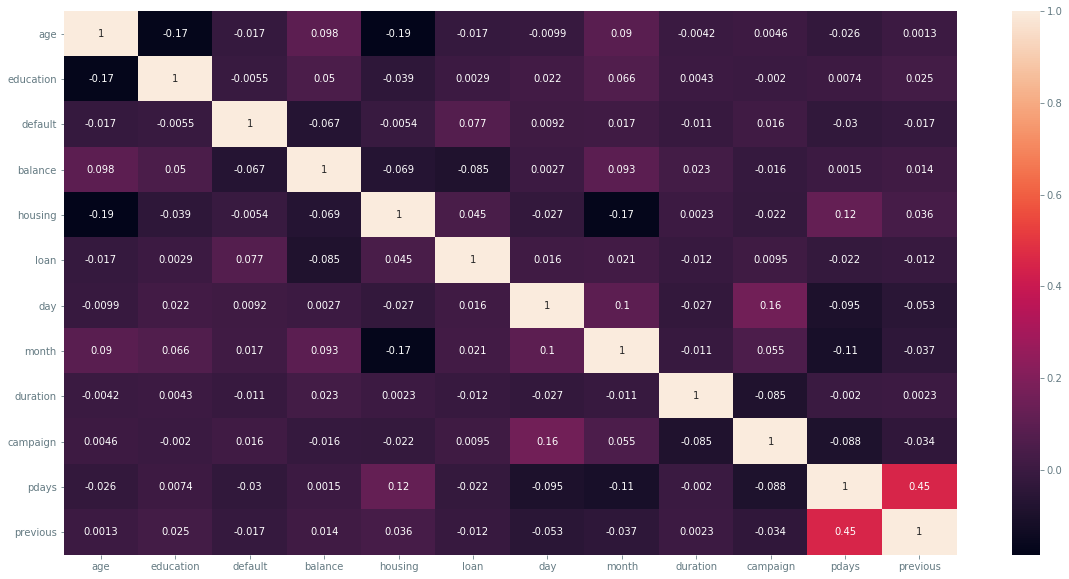

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.heatmap(corr_df.corr(), annot=True, ax=ax)
plt.plot()

### Writing Bespoke Transformers for Sklearn

In order to implement the transformation to the dataset when deploying the code, **we can write a series of classes which implement the sklearn interface for transformers.** These can then be put into an sklearn pipeline and called through the execution of the pipeline. 

The below classes are made to take in a dataframe as opposed to a standard numpy array to make the preprocessing pipeline easier to test and use for programmers.

In [64]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder
from collections import OrderedDict


class DataframeFeatureDrop(BaseEstimator, TransformerMixin):
    """
    Implements Scikit learn interface for transformers.
    
    Drop specified columns/features in a dataframe.
    """
    def __init__(self, drop_attrs):
        self.drop_attrs = drop_attrs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.drop_attrs, axis=1)
    
    
class DataframeFeatureMapping(BaseEstimator, TransformerMixin):
    """
    Implements Scikit learn interface for transformers.
    
    Maps data points to user-specified values using a dictionary,
    as opposed to default scikit learn encoders. 
    """
    def __init__(self, **kwargs):
        self.kwargs = kwargs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        tmp = X.copy()
        for col, mapping in self.kwargs.items():
            tmp.loc[:, col] = tmp.loc[:, col].apply(lambda x: mapping[x])
        return tmp
    
    
def generate_categorical_encoder(df, features_to_encode):
    encoders = OrderedDict()
    all_features = list(df.columns)
    
    for col in features_to_encode:
        if col in all_features and df.loc[:, col].dtype == object:
            col_index = all_features.index(col)
            encoders[col_index] = OrdinalEncoder()
                
    return encoders
    
    
class DataframeCategoricalEncoding(BaseEstimator, TransformerMixin):
    """
    Implements Scikit learn interface for transformers.
    
    Encodes multiple features using build in scikit learn encoders.
    """
    def __init__(self, features_to_encode):
        self.features_to_encode = features_to_encode

    def fit(self, X, y=None):
        self.__categorical_encs = generate_categorical_encoder(
            X, self.features_to_encode)
        
        for col, enc in self.__categorical_encs.items():
            enc.fit(X.values[:, col].reshape(-1, 1))
        
        return self
    
    def transform(self, X):
        encoder_attr = "_DataframeCategoricalEncoding__categorical_encs"

        if hasattr(self, encoder_attr):
            X_tmp = X.copy()
            for col, enc in self.__categorical_encs.items():
                enc_col = enc.transform(X_tmp.values[:, col].reshape(-1, 1))
                X_tmp.iloc[:, col] = enc_col.reshape(-1, 1)
            res = X_tmp
        else:
            res = self.fit_transform(X)

        return res

**Contains an example of how to use the above transformers in an sklearn pipeline.**

In [19]:
from sklearn.pipeline import Pipeline

months = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6, 
          "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}
edu = {"unknown": 0, "primary": 1, "secondary": 2, "tertiary": 3}
bin_map = {"yes": 1, "no": 0}

maps = {"month": months, "education": edu, "default": bin_map, 
        "housing": bin_map, "loan": bin_map}

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train_pipe = trn_pipe.fit_transform(X_train)
X_train_pipe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous
14565,29,3.0,1.0,1,0,0,1,0,0.0,15,7,317,3,-1,0
20546,57,4.0,0.0,2,0,396,0,0,0.0,12,8,108,2,-1,0
34495,54,1.0,1.0,1,0,714,0,0,0.0,5,5,225,1,-1,0
13814,52,7.0,1.0,2,0,2072,0,0,0.0,10,7,224,1,-1,0
42153,34,4.0,1.0,3,0,1778,0,0,0.0,4,11,358,1,162,2


### Dataset Visualisation in 2D

From the 2D visualisation, we get a sense of there are **more 0 labels than 1 labels**. Hence some kind of class-weight balancing will need to be done when fitting the data to a model. There are also many outliers with a 0 label which will affect the accuracy with which the model can fit 1s.

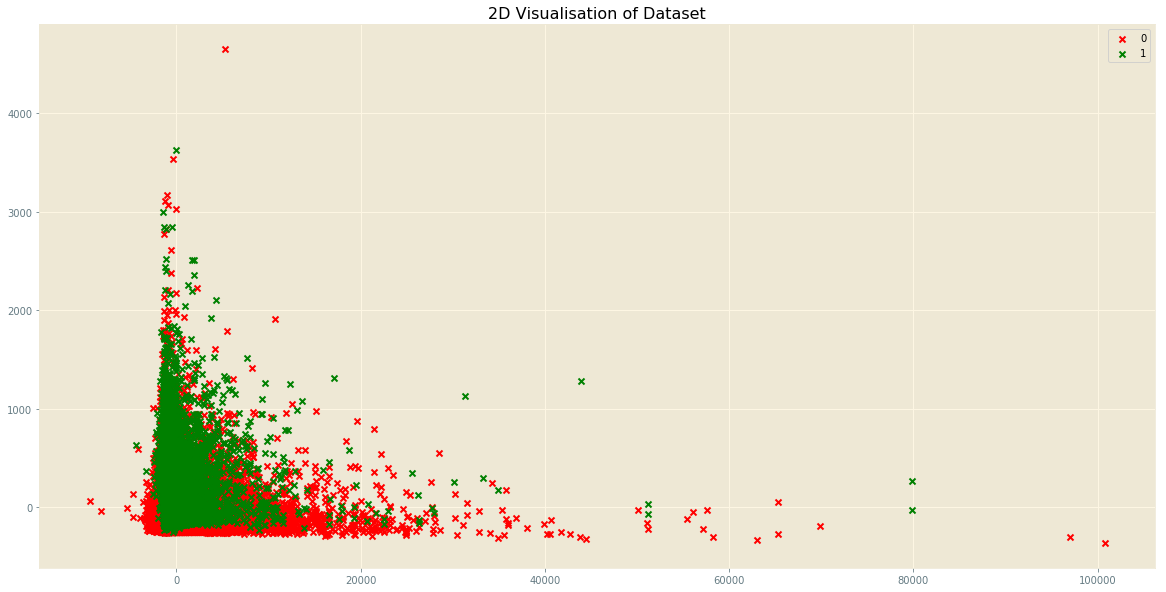

In [69]:
from sklearn.decomposition import PCA

def plot_dataset(X, y):
    pca = PCA(2, random_state=42)
    projected = pca.fit_transform(X)

    plt.figure(figsize=(20, 10))

    for i, c, label in zip(range(len(y)), 'rg', set(y)):
        plt.scatter(projected[y == i, 0], projected[y == i, 1],
                    marker='x', c=c, label=label)

    plt.title("2D Visualisation of Dataset")
    plt.legend()
    plt.show()
    
plot_dataset(X_train_pipe.values, y_train.reshape(-1))

### Removing Outliers

Outliers will be detected using the z_score metric.

In [70]:
from scipy import stats
from collections import Counter

z_threshold = 3
z = np.abs(stats.zscore(corr_df.select_dtypes("int")))
z_outliers = np.where(z > z_threshold)

if len(z_outliers[0]) < len(corr_df) * 0.05:
    corr_df.drop(corr_df.iloc[z_outliers[0]].index, inplace=True)
    
corr_df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
14565,29,housemaid,married,1,0,0,1,0,cellular,15,7,317,3,-1,0,unknown
20546,57,management,divorced,2,0,396,0,0,cellular,12,8,108,2,-1,0,unknown
34495,54,blue-collar,married,1,0,714,0,0,cellular,5,5,225,1,-1,0,unknown
13814,52,services,married,2,0,2072,0,0,cellular,10,7,224,1,-1,0,unknown
42153,34,management,married,3,0,1778,0,0,cellular,4,11,358,1,162,2,failure
19443,50,admin.,married,2,0,706,1,0,cellular,6,8,1250,4,-1,0,unknown
14942,40,technician,single,2,0,641,0,0,cellular,16,7,156,6,-1,0,unknown
3277,43,unemployed,married,1,0,960,1,1,unknown,15,5,241,2,-1,0,unknown
15158,59,retired,married,3,0,6108,1,0,cellular,17,7,796,2,-1,0,unknown
27468,53,management,married,2,0,2693,0,0,cellular,21,11,140,1,-1,0,unknown


In [73]:
def remove_outliers(X_train, y_train):
    X_tmp = X_train.copy()
    y_tmp = y_train.copy()
    
    z_threshold = 4
    z = np.abs(stats.zscore(X_train))
    z_outliers = np.where(z > z_threshold)
        
    if len(z_outliers[0]) < len(X_train) * 0.1:
        mask = np.ones(len(X_tmp), dtype=bool)
        mask[z_outliers[0]] = False
        X_tmp = X_tmp[mask, :]
        y_tmp = y_tmp[mask, :]
    else:
        pass # use imputation
    
    return X_tmp, y_tmp

x_t, y_t = remove_outliers(X_train_pipe.values, y_train)

## <span id="models"> Models </span>

As a baseline I will be using an SVM model since we have labelled data and a dataset with less than a 100k data points.

The more advance models need to take into account the fact that the data has such a large imbalance. This could be done by:
- using balanced class weights
- an ensemble model
- 

For these reasons, my more advance models will be:

1. **Random Forest Classifier** - reduces potential overfitting which we be caused by the imbalanced class ratio.

2. **Gradient Boosting Classifier** - reduces potential overfitting which we be caused by the imbalanced class ratio.

3. **Edited Nearest Neighours Classifier (ENN)** - majority instances are removed if they are not within the K-nearest neighbours.

4. **Synthetic Minority Over-sampling Technique (SMOTE)** - takes into account the K-nearest neighbours of the minority instances and then creates more data points for the minority class until the ratio of minority to majority instances reaches a given value.

#### Accuracy Metrics

In [27]:
from sklearn.metrics import accuracy_score, classification_report

In [614]:
def in_out_accuracy(fit_model, y_train, y_train_pred, y_test, y_test_pred):
    training_acc = accuracy_score(y_train, y_train_pred)
    testing_acc = accuracy_score(y_test, y_test_pred)
    
    return {"training_acc": training_acc, "testing_acc": testing_acc}

In [612]:
def display_accuracy(accuracy_dict):
    training_acc = accuracy_dict["training_acc"]
    testing_acc = accuracy_dict["testing_acc"]
    
    print(f"Training Acc: {training_acc}, Testing Acc: {testing_acc}")

#### Baseline Preprocessing

In [607]:
# Train Data Preprocessing
trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])
X_train2 = trn_pipe.fit_transform(X_train)
X_train_clean, y_train_clean = remove_outliers(X_train2.values, y_train)

### Baseline Models

In [630]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#### SVC + scaling

In [615]:
from sklearn.preprocessing import StandardScaler

svc_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", LinearSVC(random_state=41, loss="hinge"))
])

# Training
svc_pipeline.fit(X_train_clean, y_train_clean)    

# Test Data Preprocessing
X_test2 = trn_pipe.transform(X_test)

# Predictions
y_train_pred = svc_pipeline.predict(X_train_clean) # In-sample pred
y_test_pred = svc_pipeline.predict(X_test2)        # Out-of-sample pred

# Accuracy Scores
svc_scaled_res = in_out_accuracy(svc_pipeline, 
                                 y_train_clean, y_train_pred,
                                 y_test, y_test_pred)

In [620]:
display_accuracy(svc_scaled_res)

print()

print(classification_report(y_test.reshape(-1), y_test_pred,
                            target_names=["0", "1"]))

Training Acc: 0.8888714528573297, Testing Acc: 0.8774878372401592

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      3968
           1       0.00      0.00      0.00       554

   micro avg       0.88      0.88      0.88      4522
   macro avg       0.44      0.50      0.47      4522
weighted avg       0.77      0.88      0.82      4522



#### SVC + weighted class initialisation

In [623]:
svc_pipeline = Pipeline([
    ("svc", LinearSVC(random_state=41, class_weight="balanced", loss="hinge"))
])

# Training
svc_pipeline.fit(X_train_clean, y_train_clean)    

# Test Data Preprocessing
X_test2 = trn_pipe.transform(X_test)

# Predictions
y_train_pred = svc_pipeline.predict(X_train_clean) # In-sample pred
y_test_pred = svc_pipeline.predict(X_test2)        # Out-of-sample pred

# Accuracy Scores
svc_weighted_class_res = in_out_accuracy(svc_pipeline, 
                                         y_train_clean, y_train_pred,
                                         y_test, y_test_pred)

In [624]:
display_accuracy(svc_weighted_class_res)

print()

print(classification_report(y_test.reshape(-1), y_test_pred,
                            target_names=["0", "1"]))

Training Acc: 0.8914607035438734, Testing Acc: 0.8794781070322866

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      3968
           1       0.54      0.11      0.18       554

   micro avg       0.88      0.88      0.88      4522
   macro avg       0.71      0.55      0.56      4522
weighted avg       0.85      0.88      0.84      4522



#### SVC + ENN

In [230]:
import sys
!{sys.executable} -m pip install imblearn

In [628]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import make_pipeline

svc_enn_pipeline = make_pipeline(
    EditedNearestNeighbours(n_neighbors=6),
    LinearSVC(random_state=41, class_weight="balanced", loss="hinge")
)

# Training
svc_enn_pipeline.fit(X_train_clean, y_train_clean)    

# Test Data Preprocessing
X_test2 = trn_pipe.transform(X_test)

# Predictions
y_train_pred = svc_enn_pipeline.predict(X_train_clean) # In-sample pred
y_test_pred = svc_enn_pipeline.predict(X_test2)        # Out-of-sample pred

# Accuracy Scores
svc_enn_res = in_out_accuracy(svc_enn_pipeline,
                              y_train_clean, y_train_pred,
                              y_test, y_test_pred)

In [629]:
display_accuracy(svc_enn_res)

print()

print(classification_report(y_test.reshape(-1), y_test_pred,
                            target_names=["0", "1"]))

Training Acc: 0.8932914868575912, Testing Acc: 0.8794781070322866

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3968
           1       0.53      0.15      0.23       554

   micro avg       0.88      0.88      0.88      4522
   macro avg       0.71      0.56      0.58      4522
weighted avg       0.85      0.88      0.85      4522



#### Random Forest

Useful model for data with imbalance.

In [631]:
rdm_forest = RandomForestClassifier(max_depth=50, n_estimators=50, random_state=42,
                                    n_jobs=-1, max_features="sqrt")

# Training
rdm_forest.fit(X_train_clean, y_train_clean)  

# Test Data Preprocessing
X_test2 = trn_pipe.transform(X_test)

# Predictions
y_train_pred = rdm_forest.predict(X_train_clean) # In-sample pred
y_test_pred = rdm_forest.predict(X_test2)        # Out-of-sample pred

# Accuracy Scores
rdm_forest_res = in_out_accuracy(rdm_forest,
                                 y_train_clean, y_train_pred,
                                 y_test, y_test_pred)

In [632]:
display_accuracy(rdm_forest_res)

print()

print(classification_report(y_test.reshape(-1), y_test_pred,
                            target_names=["0", "1"]))

Training Acc: 0.9996861514319341, Testing Acc: 0.8971693940734189

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3968
           1       0.64      0.37      0.47       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.78      0.67      0.71      4522
weighted avg       0.88      0.90      0.89      4522



#### Random Forest + ENN

In [633]:
rdm_forest_enn_pipeline = make_pipeline(
    EditedNearestNeighbours(n_neighbors=1),
    RandomForestClassifier(max_depth=50, n_estimators=50, random_state=42,
                           n_jobs=-1, max_features="sqrt")
)

# Training
rdm_forest_enn_pipeline.fit(X_train_clean, y_train_clean)  

# Test Data Preprocessing
X_test2 = trn_pipe.transform(X_test)

# Predictions
y_train_pred = rdm_forest_enn_pipeline.predict(X_train_clean) # In-sample pred
y_test_pred = rdm_forest_enn_pipeline.predict(X_test2)        # Out-of-sample pred

# Accuracy Scores
rdm_forest_res = in_out_accuracy(rdm_forest_enn_pipeline,
                                 y_train_clean, y_train_pred,
                                 y_test, y_test_pred)

In [634]:
display_accuracy(rdm_forest_res)

print()

print(classification_report(y_test.reshape(-1), y_test_pred,
                            target_names=["0", "1"]))

Training Acc: 0.982738328756375, Testing Acc: 0.8996019460415745

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3968
           1       0.60      0.55      0.57       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.77      0.75      0.76      4522
weighted avg       0.90      0.90      0.90      4522



#### Gradient Boosting Classifier

In [637]:
gb_clf = GradientBoostingClassifier(n_estimators=9000, learning_rate=0.04, subsample=0.4,
                                     random_state=42, verbose=1, max_leaf_nodes=8, max_depth=3)

# Training
gb_clf.fit(X_train_clean, y_train_clean)  

# Test Data Preprocessing
X_test2 = trn_pipe.transform(X_test)

# Predictions
y_train_pred = gb_clf.predict(X_train_clean) # In-sample pred
y_test_pred = gb_clf.predict(X_test2)        # Out-of-sample pred

# Accuracy Scores
gb_clf_res = in_out_accuracy(gb_clf,
                             y_train_clean, y_train_pred,
                             y_test, y_test_pred)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6761           0.0163            4.91m
         2           0.6798           0.0140            4.64m
         3           0.6567           0.0133            4.64m
         4           0.6290           0.0116            4.69m
         5           0.6364           0.0096            4.65m
         6           0.6196           0.0089            4.67m
         7           0.6069           0.0085            4.70m
         8           0.6039           0.0074            4.73m
         9           0.5903           0.0064            4.67m
        10           0.5897           0.0070            4.67m
        20           0.5425           0.0036            4.49m
        30           0.5295           0.0023            4.45m
        40           0.4949           0.0010            4.41m
        50           0.4857           0.0010            4.37m
        60           0.4765           0.0010            4.35m
       

In [638]:
display_accuracy(gb_clf_res)

print()

print(classification_report(y_test.reshape(-1), y_test_pred,
                            target_names=["0", "1"]))

Training Acc: 0.974342879560612, Testing Acc: 0.9022556390977443

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      3968
           1       0.63      0.50      0.56       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.78      0.73      0.75      4522
weighted avg       0.89      0.90      0.90      4522



#### Gradient Boosting Classifier + ENN

In [641]:
gb_clf_enn_pipeline = make_pipeline(
    EditedNearestNeighbours(n_neighbors=2),
    GradientBoostingClassifier(n_estimators=4000, learning_rate=0.04, 
                               subsample=0.4, max_features=2, random_state=42,
                               verbose=1, max_leaf_nodes=8, max_depth=4)
)

# Training
gb_clf_enn_pipeline.fit(X_train_clean, y_train_clean)  

# Test Data Preprocessing
X_test2 = trn_pipe.transform(X_test)

# Predictions
y_train_pred = gb_clf_enn_pipeline.predict(X_train_clean) # In-sample pred
y_test_pred = gb_clf_enn_pipeline.predict(X_test2)        # Out-of-sample pred

# Accuracy Scores
gb_clf_enn_res = in_out_accuracy(gb_clf_enn_pipeline,
                                 y_train_clean, y_train_pred,
                                 y_test, y_test_pred)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7490           0.0092           46.72s
         2           0.7365           0.0186           44.38s
         3           0.7107           0.0183           45.75s
         4           0.7142           0.0056           45.96s
         5           0.6940           0.0163           46.58s
         6           0.6777           0.0038           47.08s
         7           0.6871           0.0128           47.25s
         8           0.6727           0.0056           47.55s
         9           0.6537           0.0141           47.45s
        10           0.6473           0.0080           47.85s
        20           0.5839           0.0022           47.51s
        30           0.5411           0.0056           49.20s
        40           0.5235           0.0016           48.67s
        50           0.4988           0.0028           48.88s
        60           0.4813           0.0009           48.24s
       

In [642]:
display_accuracy(gb_clf_enn_res)

print()

print(classification_report(y_test.reshape(-1), y_test_pred,
                            target_names=["0", "1"]))

Training Acc: 0.9277102131554859, Testing Acc: 0.9022556390977443

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3968
           1       0.59      0.69      0.63       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.77      0.81      0.79      4522
weighted avg       0.91      0.90      0.91      4522



### Feature Importance

[0.0, 0.010421328478707935, 0.02303689494421233, 0.023137885329257885, 0.027285184072775373, 0.027599600082833874, 0.028073312366962103, 0.04043078918422812, 0.05273555077808804, 0.06316999213575981, 0.09195897846678572, 0.10320138403863705, 0.11309388635152207, 0.11510918664399729, 0.28074602712623237]


[]

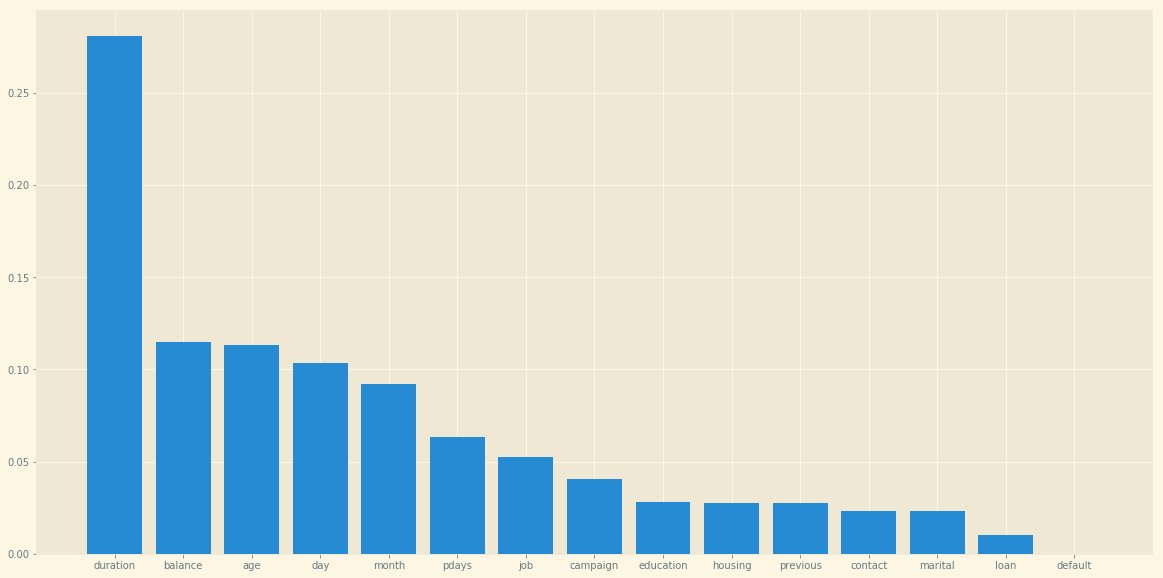

In [643]:
feature_importance = zip(X_train.columns, rdm_forest.feature_importances_)
print(sorted(rdm_forest.feature_importances_))
bar_plot = sorted(feature_importance, key=lambda x: x[1], reverse=True)
y_ticks = [y for _, y in bar_plot]
x_ticks = [x for x, _ in bar_plot]
plt.rcParams['figure.figsize'] = (20, 10)
plt.bar(x_ticks, y_ticks)
plt.plot()

### Model Comparison

Comparison of ROC curves + table of in and out sample accuracy

### Final Model

Based on the feature importance, we can use the **`SelectFromModel`** wrapper to remove less significant features. 

In [645]:
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

# Base Estimator for Feature Importance Model
feat_importance_pipeline = RandomForestClassifier(max_depth=50, n_estimators=50,
                                                  random_state=42, n_jobs=-1,
                                                  max_features="sqrt")
feat_importance_pipeline.fit(X_train_clean, y_train_clean)

# Model
pipeline = make_pipeline(
    SMOTE(n_jobs=-1, k_neighbors=4, random_state=45),
    SelectFromModel(feat_importance_pipeline, threshold=0.01),  # 0.25
    GradientBoostingClassifier(n_estimators=10000, learning_rate=0.042, subsample=0.4,
                               max_features=2, random_state=42, verbose=0,
                               max_leaf_nodes=8, max_depth=4)
)

# Training
pipeline.fit(X_train_clean, y_train_clean)

# Test Data Preprocessing
X_test2 = trn_pipe.transform(X_test)

# Predictions
y_train_pred = pipeline.predict(X_train_clean) # In-sample pred
y_test_pred = pipeline.predict(X_test2)        # Out-of-sample pred

# Accuracy Scores
pipeline_res = in_out_accuracy(pipeline,
                               y_train_clean, y_train_pred,
                               y_test, y_test_pred)

In [646]:
display_accuracy(pipeline_res)

print()

print(classification_report(y_test.reshape(-1), y_test_pred,
                            target_names=["0", "1"]))

Training Acc: 0.9615797044592651, Testing Acc: 0.8998230871295887

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3968
           1       0.62      0.49      0.54       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.77      0.72      0.74      4522
weighted avg       0.89      0.90      0.89      4522



## <span id='tuning'> Tuning </span>

### Grid Search

In [570]:
# from sklearn.model_selection import GridSearchCV

# params_dict = {"smote__random_state": [42], "smote__k_neighbors": [3, 4, 5],
#                "gradientboostingclassifier__n_estimators": [5000, 6500, 8000],
#                "gradientboostingclassifier__learning_rate": [0.04, 0.05]}

# gridsearch = GridSearchCV(pipeline, params_dict, scoring="accuracy", 
#                           n_jobs=-1, verbose=10)
# gridsearch.fit(X_train_clean, y_train_clean)

![](./grid_search_res.png)

In [535]:
# import pickle

# pickle.dump(gridsearch, open("./gridsearch.pickle", "wb"))

In [647]:
import pickle

gridsearch = pickle.load(open("./gridsearch.pickle", "rb"))

In [648]:
gridsearch.best_params_

{'gradientboostingclassifier__learning_rate': 0.04,
 'gradientboostingclassifier__n_estimators': 5000,
 'smote__k_neighbors': 4,
 'smote__random_state': 42}

In [653]:
X_test2 = trn_pipe.transform(X_test)

y_train_pred = gridsearch.best_estimator_.predict(X_train_clean)
y_test_pred = gridsearch.best_estimator_.predict(X_test2)

pipeline_res = in_out_accuracy(pipeline,
                               y_train_clean, y_train_pred,
                               y_test, y_test_pred)

In [654]:
display_accuracy(pipeline_res)

print()

print(classification_report(y_test.reshape(-1), y_test_pred,
                            target_names=["0", "1"]))

Training Acc: 0.9422780175232117, Testing Acc: 0.8998230871295887

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3968
           1       0.62      0.49      0.54       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.77      0.72      0.74      4522
weighted avg       0.89      0.90      0.89      4522



### Bayesian Search

In [546]:
import sys
!{sys.executable} -m pip install scikit-optimize

    100% |████████████████████████████████| 81kB 6.2MB/s ta 0:00:01


In [562]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args

learning_rate_name = "gradientboostingclassifier__learning_rate"
space = [Real(0.02, 0.08, "log-uniform", name=learning_rate_name)]

# Model params manually set with grid search params
model = make_pipeline(
    SMOTE(n_jobs=-1, k_neighbors=4, random_state=42),
    SelectFromModel(feat_importance_pipeline, threshold=0.01),
    GradientBoostingClassifier(n_estimators=5000, subsample=0.4, 
                               max_features=2, random_state=42, 
                               verbose=1, max_leaf_nodes=8, max_depth=4)
)

@use_named_args(space)
def objective(**params):
    print(f"Choosen learning rate: {params[learning_rate_name]}")
    
    # Setting tuning params
    model.set_params(**params)
    
    # Training and Scoring
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_clean, y_train_clean,
                             cv=cv, n_jobs=-1, verbose=10)
    
    return -np.mean(scores)

In [567]:
# from skopt import gp_minimize

# res_gp = gp_minimize(objective, space, n_calls=30,
#                      random_state=0, n_jobs=-2, verbose=10)

![](./bayesian_search_res.png)

In [565]:
# import pickle

# pickle.dump(res_gp, open("./res_gp.pickle", "wb"))

In [659]:
from skopt.plots import plot_convergence

res_gp = pickle.load(open("./res_gp.pickle", "rb"))

# plot_convergence(res_gp)
# plt.plot()

Optimal hyperparameters:

>```
{'gradientboostingclassifier__learning_rate': 0.0482922,
 'gradientboostingclassifier__n_estimators': 5000,
 'smote__k_neighbors': 4,
 'smote__random_state': 42}
```

## <span id="evaluation"> Final Evaluation </span>

In [656]:
# Features Engineering
trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])
X_train2 = trn_pipe.fit_transform(X_train)

# Removing Outliers
X_train_clean, y_train_clean = remove_outliers(X_train2.values, y_train)

# Feature Importance
feat_importance_pipeline = RandomForestClassifier(max_depth=50, n_estimators=50,
                                                  random_state=42, n_jobs=-1,
                                                  max_features="sqrt")
feat_importance_pipeline.fit(X_train_clean, y_train_clean)

# Classification Model
model = make_pipeline(
    SMOTE(n_jobs=-1, k_neighbors=4, random_state=42),
    SelectFromModel(feat_importance_pipeline, threshold=0.01),
    GradientBoostingClassifier(n_estimators=5000, subsample=0.4, 
                               max_features=2, random_state=42, 
                               verbose=1, max_leaf_nodes=8, 
                               max_depth=4, learning_rate=0.0482922)
)

# Training
model.fit(X_train_clean, y_train_clean)

# Test Data Preprocessing
X_test2 = trn_pipe.transform(X_test)

# Predictions
y_train_pred = model.predict(X_train_clean) # In-sample pred
y_test_pred = model.predict(X_test2)        # Out-of-sample pred

# Accuracy Scores
result = in_out_accuracy(model,
                         y_train_clean, y_train_pred,
                         y_test, y_test_pred)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3513           0.0344            1.93m
         2           1.3200           0.0319            2.00m
         3           1.2963           0.0231            2.03m
         4           1.2704           0.0246            2.05m
         5           1.2395           0.0319            2.11m
         6           1.2189           0.0219            2.12m
         7           1.1983           0.0187            2.11m
         8           1.1780           0.0213            2.11m
         9           1.1533           0.0229            2.13m
        10           1.1343           0.0194            2.13m
        20           0.9571           0.0159            2.09m
        30           0.8415           0.0075            2.09m
        40           0.7379           0.0105            2.10m
        50           0.6782           0.0046            2.11m
        60           0.6263           0.0040            2.08m
       

In [657]:
display_accuracy(result)

print()

print(classification_report(y_test.reshape(-1), y_test_pred,
                            target_names=["0", "1"]))

Training Acc: 0.9454949653458873, Testing Acc: 0.9026979212737727

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      3968
           1       0.63      0.51      0.56       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.78      0.73      0.75      4522
weighted avg       0.90      0.90      0.90      4522



[]

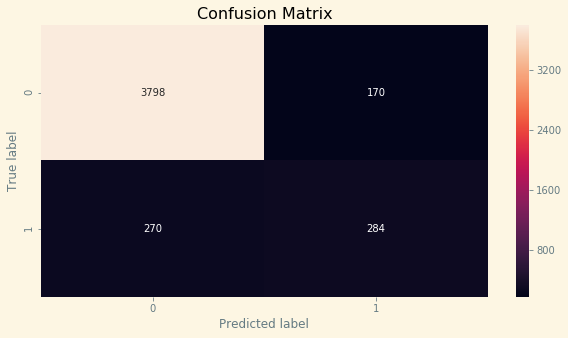

In [660]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 5))
ax = sns.heatmap(cnf_matrix, annot=True, fmt="d")

ax.set_title("Normalised Confusion Matrix")

ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

plt.plot()

## <span id="references"> References </span>